<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/Final_Results/ALL_PARAMS_DEIT_NORMAL_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install torch
!pip install torchvision
import torch

In [4]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, Normalize, ToTensor
from transformers import AutoFeatureExtractor, ViTForImageClassification

In [5]:
# Load pre-trained DeiT model
model = ViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224')

num_classes = 3
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [6]:
# Feature extractor for DeiT
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-patch16-224')

# Define image transformations
transform = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Load dataset using ImageFolder
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder("/content/drive/MyDrive/Final_Final/Train", transform=transform)
val_dataset = ImageFolder("/content/drive/MyDrive/Final_Final/Test", transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import CrossEntropyLoss

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Loss function
criterion = CrossEntropyLoss()

In [8]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Header for epoch tracking
print(f"{'Epoch':<8}{'Train Loss':<15}{'Val Loss':<15}{'Val Accuracy':<15}")
print("-" * 50)

for epoch in range(1, 11):  # Number of epochs
    # Training loop
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch}", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / len(val_dataset)

    # Log epoch results in a tabular format
    tqdm.write(f"{epoch:<8}{train_loss:<15.4f}{val_loss:<15.4f}{val_accuracy:<15.4f}")

    scheduler.step()


Epoch   Train Loss     Val Loss       Val Accuracy   
--------------------------------------------------


1       0.5633         0.3176         0.9173         


2       0.1721         0.2739         0.9121         


3       0.0858         0.2648         0.9173         


4       0.0842         0.3576         0.8966         


5       0.0717         0.3137         0.9147         


6       0.0350         0.2811         0.9251         


7       0.0315         0.2755         0.9251         


8       0.0407         0.2787         0.9173         


9       0.0289         0.2131         0.9328         


10      0.0227         0.1686         0.9483         


In [9]:
model.eval()  # Set the model to evaluation mode
val_loss, correct = 0, 0

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation Pass"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        val_loss += criterion(outputs, labels).item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

# Final loss and accuracy
val_loss /= len(val_loader)
final_accuracy = correct / len(val_dataset)

print("\nTraining Complete!")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

Final Validation Pass: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Training Complete!
Final Validation Loss: 0.2721
Final Validation Accuracy: 0.9406


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Header for epoch tracking
print(f"{'Epoch':<8}{'Train Loss':<15}{'Val Loss':<15}{'Val Accuracy':<15}")
print("-" * 50)

# Initialize lists to store values for plotting curves and confusion matrix
val_losses = []
val_accuracies = []
all_labels = []
all_preds = []

Epoch   Train Loss     Val Loss       Val Accuracy   
--------------------------------------------------


In [11]:
for epoch in range(1, 11):  # Number of epochs
    # Training loop
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch}", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = correct / len(val_dataset)

    # Log epoch results in a tabular format
    tqdm.write(f"{epoch:<8}{train_loss:<15.4f}{val_loss:<15.4f}{val_accuracy:<15.4f}")

    # Store values for later plotting
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()


1       0.0288         0.3211         0.9328         


2       0.0386         0.2011         0.9302         


3       0.0173         0.3129         0.9173         


4       0.0281         0.3197         0.9251         


5       0.0309         0.2250         0.9457         


6       0.0335         0.2616         0.8992         


7       0.0390         0.3699         0.8992         


8       0.0241         0.3167         0.9302         


9       0.0402         0.3038         0.9147         


10      0.0515         0.3736         0.9225         


In [12]:
model.eval()  # Set the model to evaluation mode
val_loss, correct = 0, 0
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation Pass"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        val_loss += criterion(outputs, labels).item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

val_loss /= len(val_loader)
final_accuracy = correct / len(val_dataset)

# Calculate other metrics
sensitivity = recall_score(all_labels, all_preds, average='binary')  # For binary classification
specificity = recall_score(all_labels, all_preds, average='binary', pos_label=0)
f1 = f1_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')
mcc = matthews_corrcoef(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)

Final Validation Pass: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


NameError: name 'recall_score' is not defined

In [ ]:
# Print final results
print("\nTraining Complete!")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Kappa: {kappa:.4f}")

In [ ]:
# Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Validation Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
import torch
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score,
                             matthews_corrcoef, cohen_kappa_score)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'all_labels' and 'all_preds' are collected from your validation loop

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
num_classes = conf_matrix.shape[0]

# Initialize variables for overall metrics
total_TP, total_FN, total_TN, total_FP = 0, 0, 0, 0

# Extract TN, FP, FN, TP and calculate per-class metrics
per_class_metrics = []
for i in range(num_classes):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    # Accumulate overall values
    total_TP += TP
    total_FN += FN
    total_FP += FP
    total_TN += TN

    # Append per-class metrics
    per_class_metrics.append({
        'class': f'Class {i}',
        'accuracy': (TP + TN) / (TP + TN + FP + FN),
        'sensitivity': TP / (TP + FN) if (TP + FN) > 0 else 0,  # Avoid division by zero
        'specificity': TN / (TN + FP) if (TN + FP) > 0 else 0,  # Avoid division by zero
    })


In [14]:
accuracy = np.trace(conf_matrix) / conf_matrix.sum()
sensitivity = total_TP / (total_TP + total_FN)
specificity = total_TN / (total_TN + total_FP)

# Calculate other metrics
precision = precision_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")
mcc = matthews_corrcoef(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)

# Print final overall values
print("\nOverall Metrics:")
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Overall Sensitivity (Recall): {sensitivity * 100:.2f}%")
print(f"Overall Specificity: {specificity * 100:.2f}%")
print(f"F1 Score (Weighted): {f1 * 100:.2f}%")
print(f"Precision (Weighted): {precision * 100:.2f}%")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# To Copy easily:
print(f"{accuracy * 100:.2f}%")
print(f"{sensitivity * 100:.2f}%")
print(f"{specificity * 100:.2f}%")
print(f"{f1 * 100:.2f}%")
print(f"{precision * 100:.2f}%")
print(f"{mcc:.4f}")
print(f"{kappa:.4f}")


Overall Metrics:
Overall Accuracy: 92.17%
Overall Sensitivity (Recall): 92.17%
Overall Specificity: 96.09%
F1 Score (Weighted): 92.15%
Precision (Weighted): 92.17%
Matthews Correlation Coefficient: 0.8812
Cohen's Kappa: 0.8810
92.17%
92.17%
96.09%
92.15%
92.17%
0.8812
0.8810


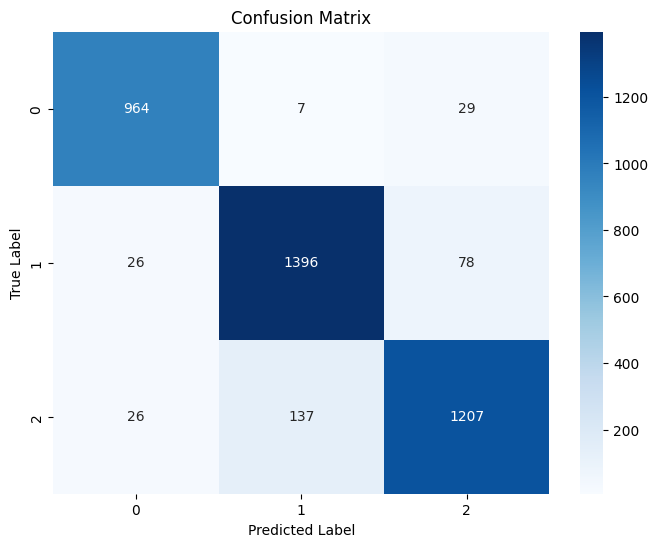

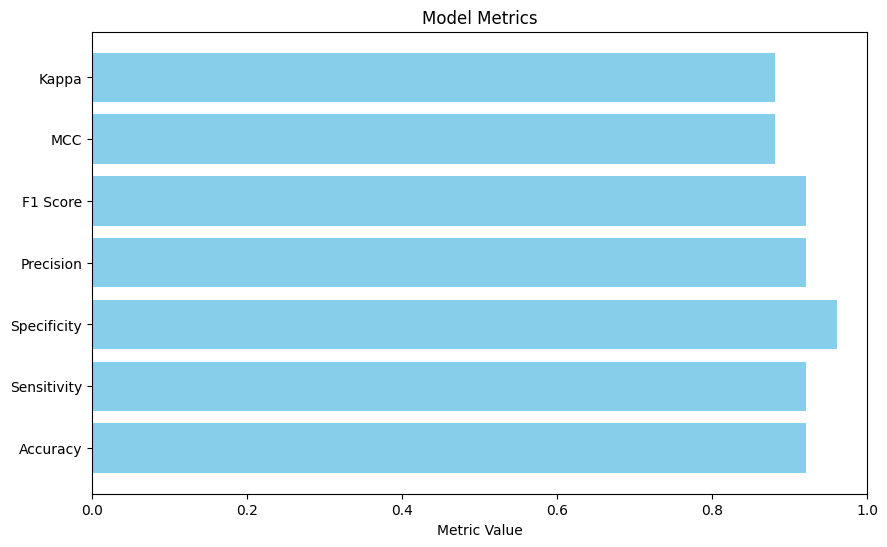

NameError: name 'pretrained_vit_results' is not defined

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot Metrics
metrics = [accuracy, sensitivity, specificity, precision, f1, mcc, kappa]
metric_names = ["Accuracy", "Sensitivity", "Specificity", "Precision", "F1 Score", "MCC", "Kappa"]

plt.figure(figsize=(10, 6))
plt.barh(metric_names, metrics, color="skyblue")
plt.xlabel("Metric Value")
plt.title("Model Metrics")
plt.xlim(0, 1)  # Metrics are between 0 and 1
plt.show()

# Assuming 'pretrained_vit_results' holds your loss and accuracy data for training and testing
epochs = range(1, len(pretrained_vit_results['train_loss']) + 1)

# Test Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, pretrained_vit_results['test_loss'], label='Test Loss', marker='o')
plt.plot(epochs, pretrained_vit_results['train_loss'], label='Training Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test and Training Loss Curve')
plt.legend()
plt.show()

print("Test Loss:", pretrained_vit_results['test_loss'][-1])
print("Training Loss:", pretrained_vit_results['train_loss'][-1])

# Test Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, pretrained_vit_results['test_acc'], label='Test Accuracy', marker='o')
plt.plot(epochs, pretrained_vit_results['train_acc'], label='Training Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test and Training Accuracy Curve')
plt.legend()
plt.show()

print("Test Accuracy:", pretrained_vit_results['test_acc'][-1])
print("Training Accuracy:", pretrained_vit_results['train_acc'][-1])